In [58]:
from transformers import RobertaTokenizer, TFRobertaModel
import datasets
import tensorflow as tf
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [13]:
inputs = tokenizer("Hello, my dog is cute, and really likes to poop on the newighbors yard at 4 am as revenge for when their dog stole it's ball.",
                   max_length= 5, return_tensors="tf", return_overflowing_tokens=True)
print(inputs)

inputs = tokenizer("Hello, my dog is cute, and really likes to poop on the newighbors yard at 4 am as revenge for when their dog stole it's ball.",
                   max_length= 3, return_tensors="tf", return_overflowing_tokens=True)
print(inputs)
#outputs = model(inputs)

#last_hidden_states = outputs.last_hidden_state

{'overflowing_tokens': <tf.Tensor: shape=(1, 29), dtype=int32, numpy=
array([[ 2335,    16, 11962,     6,     8,   269,  3829,     7, 36733,
           15,     5,    92,  8774, 19357,  6993,    23,   204,   524,
           25, 13543,    13,    77,    49,  2335,  8268,    24,    18,
         1011,     4]], dtype=int32)>, 'num_truncated_tokens': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([29], dtype=int32)>, 'input_ids': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[    0, 31414,     6,   127,     2]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 5), dtype=int32, numpy=array([[1, 1, 1, 1, 1]], dtype=int32)>}
{'overflowing_tokens': <tf.Tensor: shape=(1, 31), dtype=int32, numpy=
array([[    6,   127,  2335,    16, 11962,     6,     8,   269,  3829,
            7, 36733,    15,     5,    92,  8774, 19357,  6993,    23,
          204,   524,    25, 13543,    13,    77,    49,  2335,  8268,
           24,    18,  1011,     4]], dtype=int32)>, 'num_truncated_tokens': <tf

In [4]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    0, 31414,     6,   127,  2335,    16, 11962,     2]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [31]:
def create_wiki_set(data_set_type='train',n=10000):
    overflow = ''
    examples = []
    for i in tqdm(range(n)):
        buffer = overflow + wiki[data_set_type]['text'][i]
        if len(buffer) >= MAX_LENGTH:
            examples.append(buffer[:MAX_LENGTH])
            overflow = ''
        else:
            overflow += wiki['train']['text'][i]
    return examples


In [32]:
wiki_examples = create_wiki_set(data_set_type='train',n=10)
print(wiki_examples[0])

100%|███████████████████████████████████████████| 10/10 [00:17<00:00,  1.72s/it]

 = Valkyria Chronicles III = 
 Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs paralle


In [5]:
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.04778079,  0.08856517, -0.00979672, ..., -0.05444449,
         -0.06716338, -0.00391623],
        [-0.07121383,  0.01499833, -0.1298776 , ...,  0.06383334,
          0.02963825, -0.08603133],
        [ 0.09055017,  0.14373958,  0.08283181, ...,  0.05086066,
         -0.03197741, -0.04901589],
        ...,
        [ 0.08531624,  0.21548253,  0.08490154, ..., -0.11496733,
          0.03299987, -0.07903446],
        [ 0.16793376,  0.128793  ,  0.00646019, ...,  0.03671372,
         -0.06305141,  0.02762577],
        [-0.04356978,  0.08920526, -0.03888651, ..., -0.09573355,
         -0.07437792, -0.02838535]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-3.20835412e-03, -2.19398811e-01, -2.10875914e-01,
        -7.67211840e-02,  1.20515734e-01,  2.04878107e-01,
         2.60702759e-01, -8.43434557e-02, -7.25212172e-0

In [3]:
MAX_LENGTH = 500

In [4]:
def build_base_roberta(learning_rate = 0.00001,
                      dropout=0.3,
                      hidden_size=100):
    
    model = TFRobertaModel.from_pretrained("roberta-base")
    
    input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='attention_mask_layer')
    

    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}         

    bert_out = model(bert_inputs)[1]
    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(bert_out)
    dropped = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropped)

    
    detection_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss='binary_crossentropy', 
                            metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]) 
    return detection_model
    

In [5]:
wiki = datasets.load_dataset("wikitext",'wikitext-103-v1')

Reusing dataset wikitext (/home/brody/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1036.57it/s]


In [33]:
with open('/home/brody/school/w266/data/generated_wiki_text_10k.data', 'rb') as f:
    generated_texts = pickle.load(f)

In [4]:
len(generated_texts[0].split())

145

In [6]:
for i in generated_texts[10:20]:
    print(i)
    print('------------------------------------------------------------------------')
    print('------------------------------------------------------------------------')

. At the height of his popularity in 1882 he became one of Europe's leading entertainers. He became one of Europe's most well @-@ known musicians, selling over 10 @,@ 000 @,@ 000 albums as of 2015. He is widely regarded as one of Europe's most successful musicians, receiving accolades such as the Royal Philharmonic Lifetime Achievement Award in 2002. He was inducted into the Grammy Hall of Fame in 1988, and continues to perform at the Academy of Motion Picture Arts and Sciences every year thereafter, and has been featured on Rolling Stone's list of America's 100 Greatest Musicians of All @-@ Decade. 
 = = Early life = = 
 John Lewis Lewis was born on March 3, 1872, the youngest son of James Lewis and Margaret Alice Lewis. He grew up in New Haven, New Haven, Connecticut, where he moved with his mother and elder brother to Providence, Rhode Island when he was four years of age. Shortly thereafter, his parents emigrated to the West Indies, where it was rumoured that the Lewis family was d

In [34]:
split_gen = []
for i in generated_texts:
    split_gen.extend(i.split('\n'))

In [38]:
cleaned_gen = []
for example in generated_texts:
    if len(example) >= MAX_LENGTH:
        cleaned_gen.append(example[:MAX_LENGTH])

In [39]:
print(len(cleaned_gen))
random.shuffle(cleaned_gen)

9900


In [40]:
print(cleaned_gen[0])

 = = = 
 In 1846, an Act of Parliament passed by the English House of Burgesses was passed by the King of Great @-@ Great @-@ Yarmouth, Abbot of Lichfield, to establish a monastic parish church on Lichfield Road in Lichfield's Borough of Lichfield. At that time it consisted exclusively of abbeys, abbots who were to preside over congregations in England and Wales at that time. Abbeys were said to act as chaplains at monasteries throughout Great @-@ Great @-@ Yarmouth's Borough of Lichfield. Abbot


In [42]:
cleaned_wiki_train = create_wiki_set(data_set_type='train',n=15000)

100%|███████████████████████████████████| 15000/15000 [7:30:37<00:00,  1.80s/it]


In [47]:
print(len(cleaned_wiki_train))
print(cleaned_wiki_train[:4])

4752
[' = Valkyria Chronicles III = \n Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs paralle', " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character designer <unk> Honjou and composer Hitoshi Sakimoto both returned from previous entries , along with Valkyria Chronicles II director Takeshi Ozawa . A large team of writers handled the script . The game 's 

In [10]:
'''cleaned_wiki = []
i = 0
while len(cleaned_wiki) < len(cleaned_gen):
    example = wiki['train']['text'][i]
    if len(example) >= MAX_LENGTH:
        cleaned_wiki.append(example[:MAX_LENGTH])
    i+=1
    if i %100 == 0:
        print(i)'''

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900


In [45]:
len(cleaned_wiki)

4752

In [43]:
with open('/home/brody/school/w266/data/cleaned_generated_text_wn.data', 'wb') as f:
    pickle.dump(cleaned_gen, f)
with open('/home/brody/school/w266/data/cleaned_wiki_text_wn.data', 'wb') as f:
    pickle.dump(cleaned_wiki_train, f)

In [48]:
cleaned_wiki = cleaned_wiki_train[:len(cleaned_gen)]
print(len(cleaned_wiki))

4752


### 0 for human, 1 for bot

In [49]:
wiki_train_labels = np.array([0]*(len(cleaned_wiki)-500) + [1]*(len(cleaned_gen)-500))
wiki_val_labels = np.array([0]*500+[1]*500)

In [50]:
train_texts = cleaned_wiki[:-500] + cleaned_gen[:-500]
val_texts = cleaned_wiki[-500:] + cleaned_gen[-500:]

In [51]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')
valid_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [61]:
lengths = set()
for i in val_texts:
    lengths.add(len(i))
print(lengths)
print(train_encodings)

{250}
{'input_ids': <tf.Tensor: shape=(2084, 100), dtype=int32, numpy=
array([[   0, 2211,  267, ...,    1,    1,    1],
       [   0,   20,  177, ...,    1,    1,    1],
       [   0,   85, 1145, ...,    1,    1,    1],
       ...,
       [   0,   96,    5, ...,    1,    1,    1],
       [   0,  374,  883, ...,    1,    1,    1],
       [   0,   96,   63, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2084, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [52]:
bert_model = build_base_roberta()
bert_model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 el)                            thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                           

In [54]:
bert_model = build_base_roberta(learning_rate = 0.00001,
                      dropout=0.3,
                      hidden_size=300)
bert_model_history = bert_model.fit([train_encodings.input_ids, train_encodings.attention_mask], 
                                                  wiki_train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], 
                                                  wiki_val_labels),    
                                                  batch_size=8, 
                                                  epochs=3, shuffle=True,)  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
1707/1707 [==============================] - 194s 109ms/step - loss: 0.0237 - accuracy: 0.9895 - precision_2: 0.9874 - recall_2: 0.9974 - val_loss: 0.0013 - val_accuracy: 0.9990 - val_precision_2: 1.0000 - val_recall_2: 0.9980
Epoch 2/3
1707/1707 [==============================] - 187s 110ms/step - loss: 0.0025 - accuracy: 0.9996 - precision_2: 0.9995 - recall_2: 0.9999 - val_loss: 4.8692e-04 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/3
1707/1707 [==============================] - 187s 110ms/step - loss: 0.0025 - accuracy: 0.9994 - precision_2: 0.9993 - recall_2: 0.9999 - val_loss: 0.0043 - val_accuracy: 0.9990 - val_precision_2: 0.9980 - val_recall_2: 1.0000


In [79]:
def make_plot(axs, history1, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

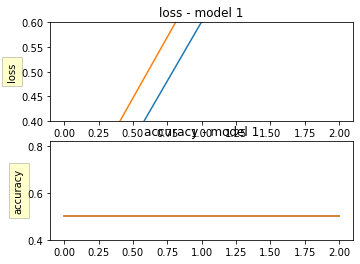

In [80]:
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          bert_model_history,
         y_lim_accuracy_lower=0.40,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [55]:
with open('/home/brody/school/w266/baseline_roberta/best_baseline.data', 'wb') as f:
    pickle.dump(bert_model, f)

INFO:tensorflow:Assets written to: ram://0c6e63bf-dd96-46e6-a842-1065152c05f5/assets


INFO:tensorflow:Assets written to: ram://0c6e63bf-dd96-46e6-a842-1065152c05f5/assets


In [57]:
bert_model.save('/home/brody/school/w266/baseline_roberta/keras_model')

INFO:tensorflow:Assets written to: /home/brody/school/w266/baseline_roberta/keras_model/assets


INFO:tensorflow:Assets written to: /home/brody/school/w266/baseline_roberta/keras_model/assets


## Tweep Fake data set

In [59]:
tweep_val = pd.read_csv('/home/brody/school/w266/tweep_fake/validation.csv')

In [66]:
tweep_val.head()

,screen_name,text,account.type,class_type,labels
0,ahadsheriff,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,human,0
1,narendramodi,India has millennia old relations with Oman. W...,human,human,0
2,jaden,Anxious Teenagers,human,human,0
3,JustinTrudeau,Our top priority is keeping Canadians safe. Wi...,human,human,0
4,imranyebot,nah bro You’re taking sis so much I’m just a g...,bot,others,1


In [64]:
tweep_val['class_type'].value_counts()

human     1150
others     436
rnn        370
gpt2       346
Name: class_type, dtype: int64

In [65]:
tweep_val['labels'] = tweep_val.apply(lambda x: 0 if x['account.type']=='human' else 1, axis=1)

In [94]:
tweep_val_human = tweep_val[tweep_val['class_type'] == 'human'].iloc[0:346]
print(tweep_val_human.head())

     screen_name                                               text  \
0    ahadsheriff  TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...   
1   narendramodi  India has millennia old relations with Oman. W...   
2          jaden                                  Anxious Teenagers   
3  JustinTrudeau  Our top priority is keeping Canadians safe. Wi...   
9         zawvrk                  @jpkayy yo this is not a bad idea   

  account.type class_type  labels  
0        human      human       0  
1        human      human       0  
2        human      human       0  
3        human      human       0  
9        human      human       0  


In [96]:
tweep_val_gpt = tweep_val[tweep_val['class_type'] == 'gpt2']
tweep_val_gpt = pd.concat([tweep_val_gpt,tweep_val_human])

In [97]:
tweep_val_labels = tweep_val_gpt['labels'].to_numpy()

In [98]:
tweep_val_gpt['labels'].value_counts()

1    346
0    346
Name: labels, dtype: int64

In [99]:
tweep_val_texts = tweep_val_gpt['text'].to_numpy().tolist()

In [100]:
tweep_val_encodings = tokenizer(tweep_val_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [101]:
results = bert_model.evaluate([tweep_val_encodings.input_ids, tweep_val_encodings.attention_mask], tweep_val_labels, batch_size=128)

6/6 [==============================] - 2s 349ms/step - loss: 3.3567 - accuracy: 0.5029 - precision_2: 0.5015 - recall_2: 0.9971


In [111]:
tweep_gpt_predictions = bert_model.predict([tweep_val_encodings.input_ids, tweep_val_encodings.attention_mask])

22/22 [==============================] - 3s 131ms/step


In [112]:
tweep_gpt_predictions

array([[9.5134312e-01],
       [9.9608564e-01],
       [9.5159858e-01],
       [9.9998069e-01],
       [9.9998546e-01],
       [9.5663303e-01],
       [9.5947099e-01],
       [9.9996650e-01],
       [9.9998450e-01],
       [9.9998331e-01],
       [9.9998367e-01],
       [9.9997365e-01],
       [9.4586021e-01],
       [9.6420127e-01],
       [9.3531227e-01],
       [9.1508782e-01],
       [9.9705637e-01],
       [9.6581626e-01],
       [9.9083602e-01],
       [9.8378122e-01],
       [9.9910033e-01],
       [9.9279988e-01],
       [9.9202067e-01],
       [9.4405621e-01],
       [9.9997127e-01],
       [9.9762183e-01],
       [9.7715306e-01],
       [9.7650015e-01],
       [9.7080022e-01],
       [9.9968672e-01],
       [9.9997270e-01],
       [9.9350172e-01],
       [9.6598190e-01],
       [9.9986756e-01],
       [9.9990284e-01],
       [9.9997866e-01],
       [9.9341398e-01],
       [9.9997592e-01],
       [9.9997771e-01],
       [9.9986339e-01],
       [9.9998415e-01],
       [9.512148

In [116]:
#bert_pred_encode = tokenizer(train_texts[4702:4802], truncation=True, padding=True, max_length=100, return_tensors='tf')

bert_predict = bert_model.predict([train_encodings.input_ids, train_encodings.attention_mask])

427/427 [==============================] - 57s 132ms/step


In [133]:
bert_predict[4200:4300]

array([[4.2755860e-06],
       [2.7211217e-06],
       [1.8595711e-05],
       [3.2195430e-06],
       [3.1999066e-06],
       [3.5889225e-06],
       [2.8994734e-06],
       [3.9225833e-06],
       [3.8584158e-06],
       [3.4489824e-06],
       [3.6142160e-06],
       [5.4012035e-06],
       [3.1920856e-06],
       [3.3419155e-06],
       [3.5553949e-06],
       [3.5484945e-06],
       [2.5294612e-06],
       [3.8700609e-06],
       [3.8703415e-06],
       [3.5436822e-06],
       [5.3957051e-06],
       [2.8228801e-06],
       [2.8636939e-06],
       [2.7957940e-06],
       [2.7072244e-06],
       [2.8786937e-06],
       [3.4626466e-06],
       [3.1666680e-06],
       [3.5914666e-06],
       [2.6139069e-06],
       [2.5625941e-06],
       [2.4315711e-06],
       [3.0796136e-06],
       [3.2618336e-06],
       [2.7170145e-06],
       [2.8772226e-06],
       [2.7359017e-06],
       [2.7387134e-06],
       [1.9781797e-05],
       [2.6770042e-06],
       [3.1006309e-06],
       [3.075971

In [132]:
zero = 0
one = 0
for i in bert_predict:
    if i < 0.01:
        zero += 1
    elif i > 0.99:
        one += 1
print(zero, one)
print(len(bert_predict))

4244 9395
13652


In [127]:
bert_train_eval = bert_model.evaluate([train_encodings.input_ids, train_encodings.attention_mask], wiki_train_labels, batch_size=128)

107/107 [==============================] - 42s 396ms/step - loss: 9.5534e-04 - accuracy: 0.9997 - precision_2: 0.9996 - recall_2: 1.0000
